###  KNN, Naive Bayes Classifier, and ROC/AUC analysis

- #### Aims:
    - ##### Implement a KNN classifier
    - ##### Implement a Naive Bayes classifier
    - ##### Compare the two classifiers with ROC and AUC

In [6]:
import numpy as np
import pylab as plt
%matplotlib inline

#### Task 1:  Implement a KNN classifier


##### Task 1.1: Load classification data
Download `trainx.csv` and `testx.csv` from Moodle. In trainx.csv, each row corresponds to an instance. The first two columns are the values for two features and the third is the class label. The same format is used in `testx.csv`. Load these datasets into python (numpy.loadtxt) and create an X matrix consisting of the first two columns and a t vector as the last one. Do the same for the test data so you have four objects: $\mathbf{X}$, $\mathbf{X}_{test}$, $\mathbf{t}$ and $\mathbf{t}_{test}$.

In [31]:
X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
Y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:,1][:,None]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(200, 112)
(200, 1)
(798, 112)


##### Task 1.2: Write a KNN function for a single test example (a row)
Implement a KNN function that takes a single test example and a value of K and returns a classification. Your function should find the K closest (see below) training points to the test point and return the majority class
amongst these training points.

If your training data is in a numpy array with 100 rows and 2 columns, then the distance between a test point and the ith row is given by:

`sq_diff = (test_row - trainx[i,:])**2
dist = np.sqrt(sq_diff.sum())`

where test_row is a row of $\mathbf{X}_{test}$.
The first line creates a new vector which holds the squared difference of the two pairs of values. The second line takes the sum of these differences and then takes the square root. This is computing the Euclidean distance. Other distance metrics could also be used.

The `zip`, `sorted` and `numpy`'s `unique` can be helpful for finding the nearest neighbours.

Make sure your function returns both the predicted class and predicted score. For KNN, the score can be the percentage of votes for each class. 

In [32]:
def knn_classifier(trainX, traint, test_data, K):
    distances = np.sqrt(((trainX - test_data)**2).sum(axis=1)) # computing distances from the testing data to all training data
    dc = zip(distances, traint) 
    dc = sorted(dc, key = lambda x: x[0]) # sort distance 
    selected_neighbor = np.asarray(dc[:K]) # select K number of neareast neighbours
    classes, counts = np.unique(selected_neighbor[:,1], return_counts=True)
    prediction = {}
    prediction["predicted_class"] = classes[counts.argmax()]
    
    if ( len(classes) == 1 and classes[counts.argmax()] == 1.0):
        prediction["predicted_score"] = np.hstack( (1.0- (1.0*counts/sum(counts)), 1.0*counts/sum(counts) ) )
    elif ( len(classes) == 1 and classes[counts.argmax()] == 0.0):
        prediction["predicted_score"] = np.hstack( ( 1.0*counts/sum(counts), 1.0- (1.0*counts/sum(counts)) ) )
    else:
        prediction["predicted_score"] = 1.0*counts/sum(counts)
    return(prediction)

##### Task 1.3: Test with a test point

In [33]:
y_prediction = []
for i in range(len(X_test)):
    c = knn_classifier(X_train,Y_train,X_test[i,:],K=20)
    y_prediction.append(c["predicted_class"])
y_prediction = np.array(y_prediction)

    
    
    
test_header = "Id,EpiOrStroma"
n_points = X_test.shape[0]
y_pred_pp = np.ones((n_points, 2))
y_pred_pp[:, 0] = range(n_points)
y_pred_pp[:, 1] = y_prediction[:,0]
print(y_pred_pp)

np.savetxt('my_submission_cl.csv', y_pred_pp, fmt='%d', delimiter=",",header=test_header, comments="")

[[  0.   2.]
 [  1.   1.]
 [  2.   2.]
 ...
 [795.   1.]
 [796.   2.]
 [797.   2.]]


##### Task 1.4: Plot Accuracy vs K 

Test your function with a range of possible `K`, and compare accuracies on all test data. Plot the results.

Text(0,0.5,'Accuracy')

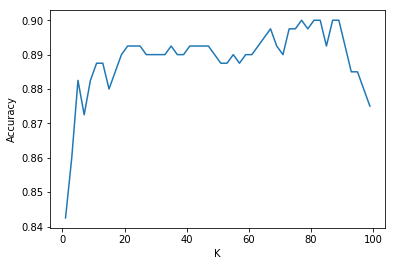

In [6]:
Kvals = np.arange(1,100,2)
accuracy = []
for k in Kvals:
    correct = 0
    for i,row in enumerate(testX):
        c = knn_classifier(trainX,traint,row,K=k)["predicted_class"]
        if c == testt[i]:
            correct += 1
    accuracy.append(1.0*correct / (1.0*len(testX)))

plt.figure()
plt.plot(Kvals,accuracy)
plt.xlabel("K")
plt.ylabel("Accuracy")

#### Task 2:  Implement a Naive Bayes classifier

##### Task 2.1: Write your function to train a Gaussian Naive Bayes classifier
We will use Gaussian distributions for each class. For each class, we fit a Gaussian to each dimension (by compute the mean and variance). The prior for each class will be the proportion of training data in that class.

In [8]:
def naive_bayes_training(trainX, traint):
    parameters = {}
    for cl in range(2):
        data_pos = np.where(traint==cl)[0]
        class_pars = {}
        class_pars['mean'] = trainX[data_pos,:].mean(axis=0)
        class_pars['vars'] = trainX[data_pos,:].var(axis=0)
        class_pars['prior'] = 1.0*len(data_pos)/len(trainX)
        parameters[cl] = class_pars
    return(parameters)

parameters = naive_bayes_training(trainX, traint)

##### Task 2.2: Write your function to make prediction on testX with the trained Gaussian Naive Bayes classifier 

Computing the likelihood for each class and multiplying by the prior, and normalise. Make sure you function also returns the probability of assigning the test data to each class.

In [9]:
def naive_bayes_prediction(parameters, tx):
    un_norm_prob = np.zeros((2,))
    for cl in parameters:
        un_norm_prob[cl] = parameters[cl]['prior']
        for i,m in enumerate(parameters[cl]['mean']):
            vari = parameters[cl]['vars'][i]
            un_norm_prob[cl] *= 1.0/np.sqrt(2.0*np.pi*vari)
            un_norm_prob[cl] *= np.exp((-0.5/vari)*(tx[i]-m)**2)
    norm_prob = un_norm_prob/un_norm_prob.sum()
    prediction = {}
    prediction['predicted_class'] = norm_prob.argmax()
    prediction['predicted_score'] = norm_prob
    return(prediction) 

##### Task 2.3:  Make predictions
Loop through the test points, 

In [10]:
predictions_nb = np.zeros((400, 3))
for j,tx in enumerate(testX):
    naive_bayes_results = naive_bayes_prediction(parameters, tx)
    predictions_nb[j, 0] = naive_bayes_results['predicted_class']
    predictions_nb[j, 1:] = naive_bayes_results['predicted_score']

Compute the accuracy of the classifier

In [11]:
accuracy = (predictions_nb[:,0] == testt).mean()
print (accuracy)

0.89


#### Task 3:  Comparing classifiers with ROC and AUC

#### Task 3.1: Plot the ROC curve for your Gaussian Naive Bayes classifier. 

In this task you can use the `roc_curve` and `roc_auc_score` function from `sklearn`

Details of `roc_curve` http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
Details of `roc_auc_score` http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html


Text(0,0.5,'Sensitivity or True Positive Rate')

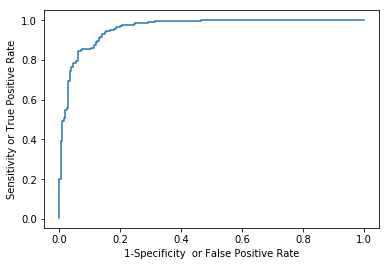

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score 

fpr_nb, tpr_nb, th_nb = roc_curve(testt, predictions_nb[:,2])

plt.plot(fpr_nb, tpr_nb)
plt.xlabel("1-Specificity  or False Positive Rate")
plt.ylabel("Sensitivity or True Positive Rate")

##### Task 3.2: Make predictions with KNN (K = 3)

In [13]:
predictions_knn = np.zeros((400, 3))
for j,tx in enumerate(testX):
    knn_results = knn_classifier(trainX, traint, tx, K = 3)
    predictions_knn[j, 0] = knn_results['predicted_class']
    predictions_knn[j, 1:] = knn_results['predicted_score']

##### Task 3.3: Overlay the two ROC curves

Text(0,0.5,'Sensitivity or True Positive Rate')

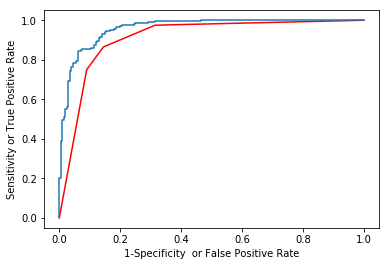

In [14]:
fpr_knn, tpr_knn, th_knn = roc_curve(testt, predictions_knn[:,2])

plt.plot(fpr_knn, tpr_knn, "r")
plt.plot(fpr_nb, tpr_nb)
plt.xlabel("1-Specificity  or False Positive Rate")
plt.ylabel("Sensitivity or True Positive Rate")

##### Task 3.4:  Compute the AUC for the two classifier 

AUCs range between 0.5 and 1. Higher AUC indicates better classifier

In [15]:
auc_knn = roc_auc_score(testt, predictions_knn[:,2])
auc_nb = roc_auc_score(testt, predictions_nb[:,2])
print(auc_knn)
print(auc_nb)


0.9110000000000001
0.95985
